In [1]:
%load_ext autoreload
%autoreload

%load_ext dotenv
%dotenv


In [2]:
import importlib
import generator.utils
importlib.reload(generator.utils)

from generator.utils import encode_entity_name
from generator.utils import find_levenshtein_match

In [3]:
USE_FIREWORKS = True

model = None

Load the LLM

In [4]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# Seems like this part is useless.
from langchain.globals import set_verbose
from langchain.globals import set_debug

#set_debug(True)
set_verbose(True)

In [5]:

from langchain_community.llms.mlx_pipeline import MLXPipeline
from langchain_community.chat_models.mlx import ChatMLX
from langchain.callbacks.tracers import ConsoleCallbackHandler

if not USE_FIREWORKS:
    print('Loading local model...')
    # Load model from huggingface, using the MLX framework to take advantage of Apple Silicon
    llm = MLXPipeline.from_model_id(
        #"mlx-community/Meta-Llama-3.1-8B-Instruct-8bit",
        #"mlx-community/Meta-Llama-3.1-8B-Instruct-bf16",
        #"mlx-community/Qwen2.5-32B-Instruct-4bit", # Let's try using a larger model, see if that improves results
        "mlx-community/Llama-3.2-3B-Instruct-8bit",
        pipeline_kwargs={
            "max_tokens": 2048,
            "temp": 0.2,
            "repetition_penalty":1.2,
            "repetition_context_size": 64
        },
    )

    # Setup verbose mode: https://stackoverflow.com/a/77629872/10914628
    model = ChatMLX(llm=llm, verbose=True)#.with_config({'callbacks': [ConsoleCallbackHandler()]})
    print('Model loaded.')


Option 2: Serverless inference with Fireworks

In [6]:
import getpass
import os

from dotenv import load_dotenv
load_dotenv()

if USE_FIREWORKS:
    if "FIREWORKS_API_KEY" not in os.environ:
        os.environ["FIREWORKS_API_KEY"] = getpass.getpass("Enter your Fireworks API key: ")

In [7]:
from langchain_fireworks import ChatFireworks

if USE_FIREWORKS:
    print('Loading Fireworks model...')
    model = ChatFireworks(
        model="accounts/fireworks/models/llama-v3-70b-instruct",
        #model="accounts/fireworks/models/llama-v3p1-405b-instruct"
        temperature=0.6,
        max_tokens=4096,
        timeout=None,
        max_retries=0,
        # other params...
    )
    print('Fireworks model loaded.')

Loading Fireworks model...
Fireworks model loaded.


Load the ontology

In [8]:
from owlready2 import *

onto = get_ontology('file://story_ontology3.rdf').load()

In [9]:
# Verify that there are no instances in the ontology (start with a clean ontology containg only the T-Box)

with onto:
    instances = list(Thing.instances())
    
    if len(instances) > 0:
        for thing in instances:
            print(thing)
        raise ValueError('Ontology already contains individuals')
    
    print('OK')

OK


Define the setting of the story

In [10]:
#setting = "Normandie viking du 9e siècle"
setting = "post-apocalypse zombie mondiale, 1 an après le début de l'épidémie"
language = "french"

# 1. Generate the outline of the story world

In [11]:
OUTLINE_TEXT_PROMPT = """
You are the master writer tasked with creating a vibrant world specifically made to host a text adventure game for a player.
Write a few paragraphs describing the world of the story following the given narrative setting:

{{ setting }}

Your text should be quite short, concise and descriptive.
Your staff will use this text as the story world bible, they will write the characters, locations and specific events.
You should direct them as precisely as possible to create as coherent and unified world for the player to explore.
Define the player's role in this world, as well as a high level, open but concrete goal, conflict and motivations.
Write your output in {{ language }}.
"""

In [12]:

prompt = PromptTemplate(
    template=OUTLINE_TEXT_PROMPT,
    template_format='jinja2'
)

#print(prompt.invoke({'setting': setting, 'language': language}).text)

chain = prompt | model

outline_text = chain.invoke({'setting': setting, 'language': language}).content

print(outline_text)

Here is the world description:

**Le Monde de la Peste**

Un an s'est écoulé depuis que l'épidémie a frappé. Les rues sont désertes, les villes sont en ruine, et les survivants sont rares. Les morts-vivants, créatures à moitié humaines et à moitié monstres, errent dans les décombres, à la recherche de leur prochaine proie. Les quelques survivants s'organisent en petits groupes, luttant pour trouver de la nourriture, de l'eau et un abri sûr.

Les grandes villes sont devenues des zones de mort, où les hordes de zombies infestent les rues et les bâtiments. Les campagnes sont un peu plus sûres, mais les ressources sont rares et les dangers sont nombreux. Les survivants doivent faire face à des bandits, des mutants et des créatures sauvages qui ont profité de la chute de la société.

**Le Rôle du Joueur**

Vous êtes un survivant, l'un des rares à avoir échappé à l'épidémie. Vous avez perdu vos proches, votre maison, et votre vie d'avant. Mais vous avez décidé de vous battre pour survivre, p

# 2. Generate locations

In [13]:
LOCATIONS_GENERATION_PROMPT = """
You are the master world writer for an interactive fiction.
On the basis of the given narrative context, create a list of locations in the world, which will be scenes in the IF.
Define at least 4 to 5 main locations, as well as intermediate locations if pertinent.
Your staff will use your work to refine each location, so you should make sure each location incoporates sufficient information for them to do so !
You must take utmost care in creating a logical topology with no islands and coherent connections.
Always refer to other locations using their "name" property in the links ! **You should define all locations mentioned in the links.**

Output your work in the following JSON format:
```json
{
    "Locations": [
        {
            "name": "Suchandsuch Town",
            "importance": "Either 'major' or 'minor', this annotation will influence how your staff will detail the"
            "description": "Description en quelques phrases du lieu, incorporant son atmosphère, son importance dans l'histoire et tout élément notable qui pourrait influencer les événements ou les personnages.",
            "links": ["Chateau thing"]
        },
        {
            "name": "Chateau thing",
            "importance": "Either 'major' or 'minor', this annotation will influence how your staff will detail the"
            "description": "Description en quelques phrases du lieu, incorporant son atmosphère, son importance dans l'histoire et tout élément notable qui pourrait influencer les événements ou les personnages.",
            "links": ["Suchandsuch Town", "Nom d'un autre lieu"]
        },
        ...
    ],
}
```

Narrative context:
{{ context }}

Your output JSON values should always be in {{ language }}
"""

In [14]:
prompt = PromptTemplate(
    template=LOCATIONS_GENERATION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser

locations_output = chain.invoke({
    'context': outline_text,
    'language': language
})

#locations_output

In [15]:
location_outlines = locations_output.get('Locations')
location_outlines

[{'name': 'La Ville de la Ruine',
  'importance': 'major',
  'description': 'Une grande ville en ruine, où les hordes de zombies infestent les rues et les bâtiments. Les survivants y sont rares et les ressources sont très limitées.',
  'links': ['La Campagne Dévastée', 'Le Quartier des Survivants']},
 {'name': 'La Campagne Dévastée',
  'importance': 'minor',
  'description': 'Une zone rurale dévastée, où les ressources sont rares et les dangers nombreux. Les survivants y vivent dans des fermes fortifiées ou des villages isolés.',
  'links': ['La Ville de la Ruine', 'Le Bois des Mutants']},
 {'name': 'Le Quartier des Survivants',
  'importance': 'major',
  'description': 'Un quartier de la ville où les survivants se sont regroupés pour se protéger mutuellement. Les ressources y sont limitées, mais les survivants y sont plus nombreux et mieux organisés.',
  'links': ['La Ville de la Ruine', 'Le Marché Noir']},
 {'name': 'Le Marché Noir',
  'importance': 'minor',
  'description': 'Un marc

Let's try to directly append new information to the KG as we go

In [16]:
# Add the generated locations to the KG
with onto:
    # Create each location entity in the graph
    for loc in location_outlines:
        loc_name = loc.get('name').strip()
        uri = encode_entity_name(loc_name)
        location = onto.Location(uri)
        
        location.label = loc_name
        location.hasName = loc_name
        location.hasDescription = loc.get('description')

        print(f'Created Location entity "{loc_name}"')
    
    # Connect each location based on their "links" property
    for loc in location_outlines:
        location = find_levenshtein_match(loc.get('name'), onto.Location.instances())
        links = loc.get('links')
        
        for other_location_name in links:
            other_uri = encode_entity_name(other_location_name)
            
            # link Location entities using the isLinkedToLocation property (symmetrical)
            other_location = find_levenshtein_match(other_location_name, onto.Location.instances())
            
            # Check if the other location exists in the ontology
            if other_location is not None:
                # Link the locations using the isLinkedToLocation property
                location.isLinkedToLocation.append(other_location)
                print(f'Linked {location.hasName} to {other_location.hasName}')
            else:
                # Print a warning or handle the missing location case as needed
                print(f"Warning: Location '{other_location_name}' with URI '{other_uri}' not found in ontology.")


Created Location entity "La Ville de la Ruine"
Created Location entity "La Campagne Dévastée"
Created Location entity "Le Quartier des Survivants"
Created Location entity "Le Marché Noir"
Created Location entity "La Route des Contrabandiers"
Created Location entity "Le Bois des Mutants"
Created Location entity "La Grotte des Réfugiés"
Created Location entity "Le Laboratoire des Scientifiques"
Created Location entity "La Ville Fortifiée"
Linked La Ville de la Ruine to La Campagne Dévastée
Linked La Ville de la Ruine to Le Quartier des Survivants
Linked La Campagne Dévastée to La Ville de la Ruine
Linked La Campagne Dévastée to Le Bois des Mutants
Linked Le Quartier des Survivants to La Ville de la Ruine
Linked Le Quartier des Survivants to Le Marché Noir
Linked Le Marché Noir to Le Quartier des Survivants
Linked Le Marché Noir to La Route des Contrabandiers
Linked La Route des Contrabandiers to Le Marché Noir
Linked La Route des Contrabandiers to Le Laboratoire des Scientifiques
Linked 

Verify that the connections were made successfully

In [17]:
with onto:
    for location in onto.Location.instances():
        print(f'{location.hasName} is connected to: {[l.hasName for l in location.INDIRECT_isLinkedToLocation]}')

La Ville de la Ruine is connected to: ['La Campagne Dévastée', 'Le Quartier des Survivants']
La Campagne Dévastée is connected to: ['La Ville de la Ruine', 'Le Bois des Mutants']
Le Quartier des Survivants is connected to: ['La Ville de la Ruine', 'Le Marché Noir']
Le Marché Noir is connected to: ['La Route des Contrabandiers', 'Le Quartier des Survivants']
La Route des Contrabandiers is connected to: ['La Grotte des Réfugiés', 'Le Marché Noir', 'Le Laboratoire des Scientifiques', 'La Ville Fortifiée']
Le Bois des Mutants is connected to: ['La Grotte des Réfugiés', 'La Campagne Dévastée']
La Grotte des Réfugiés is connected to: ['La Route des Contrabandiers', 'Le Bois des Mutants']
Le Laboratoire des Scientifiques is connected to: ['La Route des Contrabandiers', 'La Ville Fortifiée']
La Ville Fortifiée is connected to: ['La Route des Contrabandiers', 'Le Laboratoire des Scientifiques']


In [18]:
with onto:
    for location in onto.Location.instances():
        print(f'{location.hasName}: {location.hasDescription}')

La Ville de la Ruine: Une grande ville en ruine, où les hordes de zombies infestent les rues et les bâtiments. Les survivants y sont rares et les ressources sont très limitées.
La Campagne Dévastée: Une zone rurale dévastée, où les ressources sont rares et les dangers nombreux. Les survivants y vivent dans des fermes fortifiées ou des villages isolés.
Le Quartier des Survivants: Un quartier de la ville où les survivants se sont regroupés pour se protéger mutuellement. Les ressources y sont limitées, mais les survivants y sont plus nombreux et mieux organisés.
Le Marché Noir: Un marché clandestin où les survivants échangent des biens et des services. Les trafiquants et les bandits y sont nombreux, mais les survivants peuvent y trouver des ressources rares.
La Route des Contrabandiers: Une route dangereuse qui relie les différents groupes de survivants. Les contrabandiers et les bandits y sont nombreux, mais les survivants peuvent y trouver des ressources et des informations précieuses.


## Visualize the locations topology

<Figure size 1000x800 with 0 Axes>

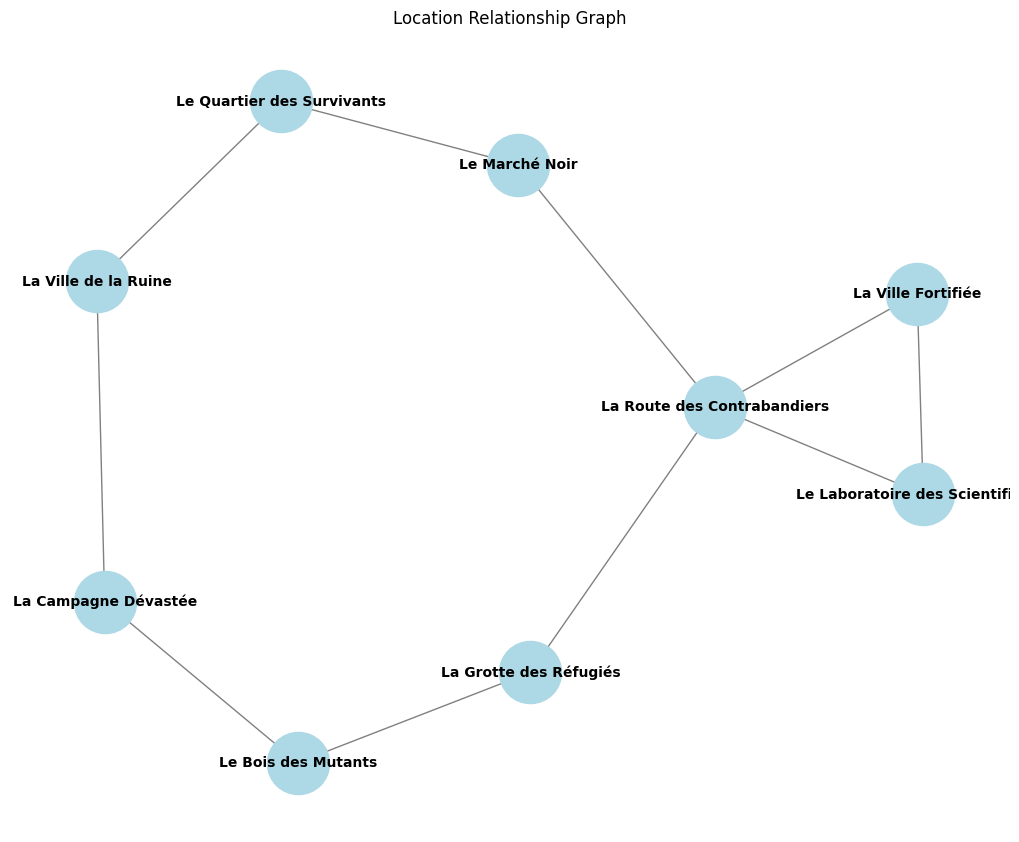

In [91]:
import networkx as nx
import matplotlib.pyplot as plt

def display_location_relationships(locations: onto.Location):
    plt.figure(figsize=(10, 8))

    # Create a graph
    G = nx.Graph()

    # Add nodes and edges
    for location in locations:
        G.add_node(location.hasName)  # Add each location as a node
        for related_location in location.INDIRECT_isLinkedToLocation:
            # Create edges for relationships
            G.add_edge(location.hasName, related_location.hasName)

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)  # Positioning of the graph

    # Draw nodes, edges, and labels
    nx.draw(G, pos,
            with_labels=True,
            node_color='lightblue',
            node_size=2000,
            font_size=10,
            font_weight='bold',
            edge_color='gray')
    plt.title('Location Relationship Graph')
    plt.show()

with onto:
    display_location_relationships(onto.Location.instances())

## Generate a structured outline of the story from the outline text and generated locations

In [20]:
STORY_OUTLINE_PROMPT = """
# Instructions pour la génération
Vous êtes le scénariste de l'histoire pour une aventure textuelle générative.
Sur la base du contexte narratif et des lieux qui composent le monde ci-dessous, générez les grandes lignes d'une histoire possible en tenant créant les éléments suivants :

    Joueur : Établir la position et le rôle du joueur dans l'histoire, en précisant leur identité, leurs motivations et leur lien avec les personnages principaux. Décrire le point de départ du joueur et son rôle dans le récit global.
    Personnages: Etablir une liste d'au moins **3 à 5** personnages principaux de l'histoire, sans rentrer dans trop de détails mais en évoquant leur fonction narrative et leurs relations (entre eux et avec le joueur). Veille à établir au moins un antagoniste principal.
    Objectif : Définir l'objectif global du joueur, en précisant le problème principal à résoudre ou l'enjeu narratif qui motive l'action.
    Événements : Décrire au moins 1 à 3 événements clés qui alimentent l'histoire et doivent être déclenchés par l'action du joueur.
    Objets : Générer uniquement les éléments essentiels nécessaires pour compléter l'histoire (objets de quête) si c'est mentionné dans le contexte narratif, en incluant : Un nom et une description de chaque objet, avec sa fonction dans le récit. Indiquer le lieu où se trouve chaque objet, en s'assurant qu'il s'intègre logiquement dans le monde.
    Commentaires : Inclure tout commentaire supplémentaire qui pourrait guider la génération de détails supplémentaires ou éclaircir des éléments importants de l'histoire.

# Format de sortie
D'abord, raisonner sur le contexte narratif donné et son importance pour la cohérence du monde et de l'histoire, l'intrigue principale (qui doit être de nature ouverte), et les relations des personnages.
Fournir les éléments dans un fichier json structuré selon le format suivant:
```json
{
    "Player": {
        "name": "Donner le nom du personnage qu'incarne le joueur",
        "description": "Description en quelques phrases du personnage qu'incarne le joueur",
        "location": "Nom du lieu de départ de l'histoire"
    },
    "Characters": [
        {
            "name": "Nom propre du personnage 1",
            "description": "description en une phrase du personnage, incorporant son rôle et sa fonction dans l'histoire, et sa relation aux autres personnages.",
            "location": "Nom du lieu ou se trouve le personnage"
        },
        ...
    ],
    "Goal": {
        "description": "description du problème ou de l'enjeu qui motive le joueur. La résolution du jeu doit rester ouverte",
        "requiresItem": "(FACULTATIF) S'il un objet qui est le centre de l'histoire et doit être récupéré pour gagner, l'indiquer ici. Sinon, omettre ce champs."
    },
    "Events": [
        {
            "name": "Evènement 1",
            "description": "description de l'évènement",
            "condition": "description de la condition qui déclenche l'évènement (**doit** être déclenché par l'action du joueur !)",
            "consequence": "Description des conséquences à l'évènement. Ces conséquences doivent être concrètes pour le joueur",
            "location": "Nom du lieu où se déroule l'évènement. Si l'évènement est global, ne pas remplir ce champ."
        },
        ...
    ],
    "Items": [
        {
            "name": "Nom de l'objet",
            "description": "description courte de l'objet et de sa fonction dans le récit",
            "location": "(OBLIGATOIRE) Nom du lieu qui contient l'objet"
        },
        ...
    ],
    "Comments": [
        "Tout commentaire que tu voudrais ajouter pour guider la génération de détails supplémentaires et pendant le jeu. Sois précis plus que général: donne des commentaires qui peuvent être exploités. Des éléments importants de l'histoire"
    ]
}
```

Make sure to output VALID JSON with no missing commas or other syntax errors.

# Lieux du monde
{%- for location in locations %}
- "{{location.hasName}}": {{location.hasDescription}}
  "{{location.hasName}}" mène à {%- for loc in location.INDIRECT_isLinkedToLocation %} "{{loc.hasName}}" {%- endfor %}
{%- endfor %}

# Contexte narratif
{{ setting }}

Rappel: Ne répète pas les lieux du monde. Ton objectif est de développer une histoire qui fonctionne dans ce monde. N'ajoute que des éléments nouveaux dans le JSON. Fournis seulement les informations sur le joueur, son objectif, les personnages principaux, les évènements principaux, les éventuels objets principaux.
Ecris en {{language}}, sauf pour les clés JSON qui doivent rester comme dans l'exemple.

# Résultat
"""

In [21]:
prompt = PromptTemplate(
    template=STORY_OUTLINE_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser

with onto:
    # print(prompt.invoke({
    #     'setting': outline_text,
    #     'language': language,
    #     'locations': onto.Location.instances()
    # }).text)
    story_outline = chain.invoke({
        'setting': outline_text,
        'language': language,
        'locations': onto.Location.instances()
    })

In [22]:
story_outline

{'Player': {'name': 'Alexandre Dumont',
  'description': "Un survivant déterminé à retrouver un sens à sa vie après avoir perdu ses proches dans l'épidémie.",
  'location': 'Le Quartier des Survivants'},
 'Characters': [{'name': 'Dr. Sophia Patel',
   'description': "Une scientifique déterminée à trouver un remède à l'épidémie, qui dirige le laboratoire des scientifiques.",
   'location': 'Le Laboratoire des Scientifiques'},
  {'name': 'Marcus Blackwood',
   'description': "Un leader charismatique d'un groupe armé qui cherche à prendre le contrôle de la ville fortifiée et du laboratoire.",
   'location': 'La Route des Contrabandiers'},
  {'name': 'Lena Lee',
   'description': "Une survivante qui a perdu sa famille et qui cherche à se venger des responsables de l'épidémie.",
   'location': 'Le Marché Noir'},
  {'name': 'Raphaël',
   'description': 'Un survivant qui a trouvé refuge dans la grotte des réfugiés et qui cherche à rejoindre le laboratoire.',
   'location': 'La Grotte des Réfu

Add the new items to the KG

In [23]:
# Add Events
with onto:
    for event_data in story_outline.get('Events'):
        
        event_name = event_data.get('name').strip()
        encoded_event_name = encode_entity_name(event_name)
        
        event = onto.Event(event_name)
        event.hasName = event_name
        event.label = event_name
        event.hasDescription = event_data.get('description')
        event.hasCondition = event_data.get('condition')
        event.hasConsequence = event_data.get('consequence')
        print(f'Created Event entity "{event_name}"')
        print(f'Description: {event.hasDescription}')
        print(f'Condition: {event.hasCondition}')
        print(f'Consequence: {event.hasConsequence}\n')


Created Event entity "La Rencontre avec Lena"
Description: Vous rencontrez Lena Lee au Marché Noir, qui vous propose de vous aider à rejoindre le laboratoire en échange d'une aide pour se venger.
Condition: Vous avez acheté des informations sur le laboratoire au Marché Noir.
Consequence: Lena vous rejoint et vous aide à traverser les zones de mort.

Created Event entity "L'Attaque de Marcus"
Description: Marcus Blackwood et son groupe armé attaquent le Quartier des Survivants pour prendre le contrôle.
Condition: Vous avez refusé de rejoindre le groupe de Marcus précédemment.
Consequence: Le Quartier des Survivants est dévasté et les survivants sont tués ou blessés.

Created Event entity "La Découverte du Laboratoire"
Description: Vous découvrez l'emplacement du laboratoire des scientifiques après avoir traversé la Route des Contrabandiers.
Condition: Vous avez traversé la Route des Contrabandiers sans être tué.
Consequence: Vous pouvez rejoindre le laboratoire et aider les scientifique

In [24]:
# Add Characters
with onto:
    for char in story_outline.get('Characters'):
        print('DEBUG: ', char)
        # First, make sure the location is correct
        loc_name = char.get('location')
        character_location = find_levenshtein_match(loc_name, onto.Location.instances())
        
        if not character_location:
            print(f"Warning: {name}'s location {loc_name} not found in ontology. ")
            continue
        
        # Create new character
        name = char.get('name')
        encoded_name = encode_entity_name(name)
        
        character = onto.Character(encoded_name)
        character.hasName = name
        character.label = name
        character.hasDescription = char.get('description')
        character.hasImportance = 'main character' 
        character.characterIsLocatedAt = character_location

        print(f'{character.hasName} ({character.INDIRECT_isLocatedAt.hasName}): {character.hasDescription}')

DEBUG:  {'name': 'Dr. Sophia Patel', 'description': "Une scientifique déterminée à trouver un remède à l'épidémie, qui dirige le laboratoire des scientifiques.", 'location': 'Le Laboratoire des Scientifiques'}
Dr. Sophia Patel (Le Laboratoire des Scientifiques): Une scientifique déterminée à trouver un remède à l'épidémie, qui dirige le laboratoire des scientifiques.
DEBUG:  {'name': 'Marcus Blackwood', 'description': "Un leader charismatique d'un groupe armé qui cherche à prendre le contrôle de la ville fortifiée et du laboratoire.", 'location': 'La Route des Contrabandiers'}
Marcus Blackwood (La Route des Contrabandiers): Un leader charismatique d'un groupe armé qui cherche à prendre le contrôle de la ville fortifiée et du laboratoire.
DEBUG:  {'name': 'Lena Lee', 'description': "Une survivante qui a perdu sa famille et qui cherche à se venger des responsables de l'épidémie.", 'location': 'Le Marché Noir'}
Lena Lee (Le Marché Noir): Une survivante qui a perdu sa famille et qui cherch

In [25]:
# Verify results
with onto:
    #sync_reasoner()
    for loc in onto.Location.instances():
        print(f"{loc.hasName}: {[char.hasName for char in loc.containsCharacter]}")

La Ville de la Ruine: []
La Campagne Dévastée: []
Le Quartier des Survivants: []
Le Marché Noir: ['Lena Lee']
La Route des Contrabandiers: ['Marcus Blackwood']
Le Bois des Mutants: []
La Grotte des Réfugiés: ['Raphaël']
Le Laboratoire des Scientifiques: ['Dr. Sophia Patel']
La Ville Fortifiée: []


In [26]:
# Add Items
for item_data in story_outline.get('Items'):
    print('DEBUG: ', item_data)
    item_name = item_data.get('name')
    encoded_name = encode_entity_name(encoded_name)
    
    item = onto.Item(encoded_name)
    item.hasName = item_name
    item.label = item_name
    item.hasDescription = item_data.get('description')
    item.hasQuantity = item_data.get('quantity', 1)
    item.hasImportance = 'major'
    
    item_location_name = item_data.get('location')
    
    # Find the location among existing locations using fuzzy matching (using Levenshtein distance)
    item_location = find_levenshtein_match(item_location_name, onto.Location.instances())
    
    if not item_location:
        print(f"Warning: item's location {item_location_name} not found in ontology.")
        continue
    
    item.itemIsLocatedAt = item_location

    print(f'{item.hasName} ({item.INDIRECT_isLocatedAt.hasName}): {item.hasDescription}')
    

DEBUG:  {'name': 'Le Dossier de Recherche', 'description': "Un dossier contenant des informations sur l'épidémie et le remède possible.", 'location': 'Le Laboratoire des Scientifiques'}
Le Dossier de Recherche (Le Laboratoire des Scientifiques): Un dossier contenant des informations sur l'épidémie et le remède possible.
DEBUG:  {'name': 'La Carte de la Route des Contrabandiers', 'description': 'Une carte qui indique les routes les plus sûres pour traverser la Route des Contrabandiers.', 'location': 'Le Marché Noir'}
La Carte de la Route des Contrabandiers (Le Marché Noir): Une carte qui indique les routes les plus sûres pour traverser la Route des Contrabandiers.


In [27]:
print(f'{item.hasName} ({item.INDIRECT_isLocatedAt.hasName}): {item.hasDescription}')


La Carte de la Route des Contrabandiers (Le Marché Noir): Une carte qui indique les routes les plus sûres pour traverser la Route des Contrabandiers.


In [28]:
# Player and player's goal
with onto:
    # Create the Player entity
    player_data = story_outline.get('Player')
    player_name = player_data.get('name')
    encoded_name = encode_entity_name(player_name)
    
    player = onto.Player(encoded_name)
    player.hasName = player_name
    player.label = player_name
    player.hasDescription = player_data.get('description')
    player.hasImportance = 'Player'
    
    # Give the player its location
    player_location_name = player_data.get('location')
    
    player_location = find_levenshtein_match(player_location_name, onto.Location.instances())
    
    if player_location:
        player.characterIsLocatedAt = player_location
    else:
        print(f"Warning: {player_name}'s location {player_location_name} not found in ontology. ")
    
    goal_data = story_outline.get('Goal')
    # Create the player's Goal entity
    goal_description = goal_data.get('description')
    
    goal = onto.Goal('player_goal')
    goal.label = 'Player goal'
    goal.hasDescription = goal_description

    required_item_name = goal_data.get('requiresItem')
    print(f"Required item name: {required_item_name}")
    required_item = find_levenshtein_match(required_item_name, onto.Item.instances())
    print(f"Required item: {required_item.hasName if required_item else 'None'}")
    if required_item:
        goal.requiresItem.append(required_item)
    
    print(goal)
    player.hasGoal.append(goal)

    print(f'{player.hasName} ({player.INDIRECT_isLocatedAt.hasName}): {player.hasDescription}')
    print(f'Goal: {player.hasGoal[0].hasDescription}')
    print(f'Requires item: {player.hasGoal[0].requiresItem}')

Required item name: Le dossier de recherche sur l'épidémie
Required item: None
story_ontology3.player_goal
Alexandre Dumont (Le Quartier des Survivants): Un survivant déterminé à retrouver un sens à sa vie après avoir perdu ses proches dans l'épidémie.
Goal: Rejoindre le laboratoire des scientifiques pour aider à développer un remède à l'épidémie.
Requires item: []


In [29]:
CHARACTER_EXPANSION_PROMPT = """
Using the following details, generate a JSON output with additional information about the character.

Character Name: {{character.hasName}}
Description: {{character.hasDescription}}
Starting location: {{character.isLocatedAt.hasName}}

Other main characters of the story:
{%- for char in other_characters %}
    "{{ char.hasName }}": {{ char.hasDescription }} (is located at {{char.INDIRECT_isLocatedAt.hasName}})
{%- endfor %}

The player:
    "{{ player.hasName }}": {{ player.hasDescription }} (is located at {{player.INDIRECT_isLocatedAt.hasName}})
    The player has the goal: {{player.hasGoal[0].hasDescription}}

Please include:
- A significant backstory element that explain their current situation. Improving the character's current description
- One or two relationships that the character has with other main characters or the player.

Ensure that all generated elements align with the narrative and character dynamics already established in the outline.
Output your response in the exact following JSON format:

```json
{
    "description": "The updated, expanded description of the character, defining their goals, motivations, and conflicts, all inside this description string",
    "relationships": [
        {
            "type": "The type of relationship from this character to the target character. Either 'knows', 'friend', 'lover', 'enemy', 'rival', 'subject', 'ruler', no matter the language ",
            "target": "Name of the character which has that relationship with {{character.hasName}}"
        },
        ...
    ]
}
```

**The relationship types should be chosen EXCLUSIVELY between: 'knows', 'friend', 'lover', 'enemy', 'rival', 'subject', 'ruler', no matter the language !!**

Write all the JSON value strings in {{language}}, except relationship types.
"""

In [30]:

prompt = PromptTemplate(
    template=CHARACTER_EXPANSION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser

characters = onto.Character.instances()

# Expand each character's description and relationships
for character in characters:
    if onto.Player in character.is_a:
        continue
    
    print(character.hasName)
    
    # Get the list of other main characters
    other_characters = list()
    for other_character in characters:
        # skip self
        if other_character.hasName == character.hasName:
            continue
        other_characters.append(other_character)
    
    print(character)
    
    # print(prompt.invoke({"setting": outline_text,
    #                     "character": character,
    #                     "player": onto.Player.instances()[0],
    #                     "other_characters": other_characters,
    #                     "language": language}).text)
    # continue

    res = chain.invoke({"setting": outline_text,
                        "character": character,
                        "player": onto.Player.instances()[0],
                        "other_characters": other_characters,
                        "language": language})

    # Update the character in the ontology
    character.hasLongDescription = res.get('description')

    for relationship in res.get('relationships'):
        #'friend', 'lover', 'enemy', 'rival', 'subject', 'ruler'
        relationship_type = relationship.get('type')
        related_character_name = relationship.get('target')
        related_character = find_levenshtein_match(related_character_name, onto.Character.instances())
        
        if not related_character:
            print(f"Warning: {character.hasName}'s relation {related_character_name} not found in ontology.")
            continue
            
        if relationship_type == 'friend':
            character.hasFriendshipWith.append(related_character)
        elif relationship_type == 'lover':
            character.loves.append(related_character)
        elif relationship_type == 'enemy':
            character.isEnemyWith.append(related_character)
        elif relationship_type == 'rival':
            character.hasRivalryWith.append(related_character)
        elif relationship_type == 'subject':
            character.hasAllegiance.append(related_character)
        elif relationship_type == 'ruler':
            character.isRulerOf.append(related_character)
            #related_character.hasAllegiance = [this_character]
        elif relationship_type == 'knows':
            character.knows.append(related_character)

    print('----*----')
    print(res)
    print('\n\n')
    print(f"Name: {character.hasName}")
    print(f"Location: {character.INDIRECT_isLocatedAt.hasName}")
    print(f"Description: {character.hasDescription}")
    print(f"Long description: {character.hasLongDescription}")
    print(f"Knows: {character.INDIRECT_knows}")
    print(f"Friends: {character.INDIRECT_hasFriendshipWith}")
    print(f"Rivals: {character.INDIRECT_hasRivalryWith}")
    print(f"Enemies: {character.INDIRECT_isEnemyWith}")
    print(f"Has allegiance to: {character.INDIRECT_hasAllegiance}")
    print(f"Is ruler of: {character.INDIRECT_isRulerOf}")
    print(f"Loves: {character.INDIRECT_loves}")
    #print(f"Relationships: {character.}")
    print('----*----')

Dr. Sophia Patel
story_ontology3.dr.%20sophia%20patel
----*----
{'description': "Une scientifique déterminée à trouver un remède à l'épidémie, qui dirige le laboratoire des scientifiques. Ayant perdu sa sœur dans l'épidémie, elle est motivée par la culpabilité et la responsabilité de trouver un remède pour sauver les autres. Elle est prête à tout pour atteindre son but, même si cela signifie prendre des risques élevés et faire face à l'opposition de groupes armés.", 'relationships': [{'type': 'knows', 'target': 'Marcus Blackwood'}, {'type': 'friend', 'target': 'Alexandre Dumont'}]}



Name: Dr. Sophia Patel
Location: Le Laboratoire des Scientifiques
Description: Une scientifique déterminée à trouver un remède à l'épidémie, qui dirige le laboratoire des scientifiques.
Long description: Une scientifique déterminée à trouver un remède à l'épidémie, qui dirige le laboratoire des scientifiques. Ayant perdu sa sœur dans l'épidémie, elle est motivée par la culpabilité et la responsabilité de 

In [31]:
# Verify consistency and make inferences
# with onto:
#     sync_reasoner()

Great ! We have expanded our characters ! They now have relationships and backstories, this should be interesting !


## Expand Locations

In [32]:
LOCATION_EXPANSION_PROMPT = """
Using the following details, generate a JSON output with additional information about the location.

Setting of the story: {{setting}}

Location Name: {{location.hasName}}
Description: {{location.hasDescription}}
Neighboring locations:
{%- for nearby_location in location.INDIRECT_isLinkedToLocation %}
    - "{{ nearby_location.hasName }}": {{nearby_location.hasDescription}}
{%- endfor %}

{%- if location.containsCharacter %}
Main characters in "{{location.hasName}}":
{%- for character in location.containsCharacter %}
    - "{{ character.hasName }}" {% if onto.Player in character.is_a %}(Player){%- endif %}: {{ character.hasDescription }}
{%- endfor %}
{%- endif %}

{%- if location.containsItem %}
The location contains the quest item(s):
{%- for item in location.containsItem %}
    - "{{ item.hasName }}" ({{item.hasImportance}}): {{ item.hasDescription }}
{%- endfor %}
{%- endif %}

Please DO NOT include this information in your output

Please include:
- Up to two secondary characters that would be relevant to this location. Keep in mind that secondary caracters should have a use to the player, that is either to give the player some important information (define specifically the information), some items, trade or offer a challenge, or other if it is relevant to the scene and the story. You can and should use less, or even no characters, depending on the location ! Only add characters where pertinent.
- Up to three items that could be found or are important in this location. Items should always have a clear use at least in the scene.

You CAN add less characters and items than requested, but you MUST NOT add more than requested.

Do not call any character these names: {{banned_character_names}}
Do not call any item these names: {{banned_item_names}}
{%- if used_roles %}
Already used secondary character roles (Try not to repeat them too much. Only if it really makes sense): {{used_roles}}
{%- endif %}

Ensure that all generated elements align with the narrative and character dynamics already established in the outline.

Make sure to output the list of characters as JSON, following this exact model:

```json
{
    "Description": "A longer, more detailed description of the location and perhaps its different parts and their function in the story",
    "Characters": [
        {
            "name": "The name of the character",
            "description": "A concise description of the character and their function in the scene.",
            "role": "One or two words describing this character's function"
        },
        ...
    ],
    "Items": [
        {
            "name": "The name of the item",
            "description": "A concise description of the item and its state and function.",
            "quantity": 1
        },
        ...
    ]
}
```

Generate all output in {{ language }}
"""

In [33]:

prompt = PromptTemplate(
    template=LOCATION_EXPANSION_PROMPT,
    template_format='jinja2'
)

parser = JsonOutputParser()

chain = prompt | model | parser


# banned_character_names = all_character_names
# banned_item_names = all_item_names


for location in onto.Location.instances():
    print(f"Name: {location.hasName}")
    print(location.containsCharacter)

    # Prevent LLM from generating the same items over and over.
    # This improves creativity, and coherence between prompts, since the LLM is
    # at least aware of what kind of items already exist.
    banned_item_names = [i.hasName for i in onto.Item.instances()]
    banned_character_names = [c.hasName for c in onto.Character.instances()]
    used_roles = [c.hasRole for c in onto.Character.instances() if c.hasRole]

    # print(prompt.invoke({"setting": outline_text,
    #                      "onto": onto,
    #                      "location": location,
    #                      "banned_item_names": banned_item_names,
    #                      "banned_character_names": banned_character_names,
    #                      "used_roles": used_roles,
    #                      "language": language}).text)
    # break

    res = chain.invoke({"setting": outline_text,
                        "onto": onto,
                        "location": location,
                        "banned_item_names": banned_item_names,
                        "banned_character_names": banned_character_names,
                        "used_roles": used_roles,
                        "language": language})

    print(res)

    # Update KG with this expanded information
    # Updated long description
    location.hasLongDescription = res.get('Description')
    
    # New secondary Characters
    for char in res.get('Characters'):
        char_name = char.get('name')
        encoded_char_name = encode_entity_name(char_name)
        
        character = onto.Character(encoded_char_name)
        character.hasName = char_name
        character.label = char_name
        character.hasDescription = char.get('description')
        character.hasRole.append(char.get('role'))
        character.hasImportance = 'secondary'
        character.characterIsLocatedAt = location
    
    for item_data in res.get('Items'):
        item_name = item_data.get('name')
        encoded_item_name = encode_entity_name(item_name)
        
        item = onto.Item(encoded_item_name)
        item.hasName = item_name
        item.label = item_name
        item.hasDescription = item_data.get('description')
        item.hasImportance = 'minor'
        item.itemIsLocatedAt = location

    print('\n')
    print(f"Location name: {location.hasName}")
    print(f"Description: {location.hasDescription}")
    print(f"Long description: {location.hasLongDescription}")
    print(f"Characters: {location.INDIRECT_containsCharacter}")
    print(f"Items: {location.INDIRECT_containsItem}")
    print('----*----')

Name: La Ville de la Ruine
[]
{'Description': 'Une grande ville en ruine, où les hordes de zombies infestent les rues et les bâtiments. Les survivants y sont rares et les ressources sont très limitées. Les immeubles sont délabrés, les vitres brisées, et les débris de véhicules jonchent les rues. Les zombies errent sans but, à la recherche de leur prochaine proie.', 'Characters': [{'name': 'Émilie LaFleur', 'description': "Une survivante qui a perdu sa famille dans l'épidémie. Elle est désormais seule et errante, à la recherche de ressources pour survivre. Elle connaît bien la ville et pourrait donner des informations précieuses au joueur sur les lieux à éviter et les ressources à trouver.", 'role': 'Informateur'}, {'name': 'Gaspard Lebrun', 'description': 'Un trafiquant qui a établi un réseau de contrebande dans la ville. Il pourrait proposer au joueur une échange de ressources contre des informations sur le laboratoire des scientifiques ou des armes pour se défendre.', 'role': 'Marcha

In [34]:
with onto:
    for character in onto.Character.instances():
        loc = character.INDIRECT_isLocatedAt

        print(f"{character.hasName} is located at {loc.hasName}")

    
    for location in onto.Location.instances():
        characters = location.INDIRECT_containsCharacter
        print(f"{location.hasName} contains: {[c.hasName for c in characters]}")

Dr. Sophia Patel is located at Le Laboratoire des Scientifiques
Marcus Blackwood is located at La Route des Contrabandiers
Lena Lee is located at Le Marché Noir
Raphaël is located at La Grotte des Réfugiés
Émilie LaFleur is located at La Ville de la Ruine
Gaspard Lebrun is located at La Ville de la Ruine
Aurélie Dupont is located at La Campagne Dévastée
Léonard Marchal is located at La Campagne Dévastée
Léa Rousseau is located at Le Quartier des Survivants
Pierre Martin is located at Le Quartier des Survivants
Camille Dumont is located at Le Marché Noir
Gérard Moreau is located at Le Marché Noir
Léonie Dupuis is located at La Route des Contrabandiers
Gilles Lefebvre is located at La Route des Contrabandiers
Adèle Laforest is located at Le Bois des Mutants
Gabin Lefort is located at Le Bois des Mutants
Léon is located at La Grotte des Réfugiés
Anaïs is located at La Grotte des Réfugiés
François Dumont is located at Le Laboratoire des Scientifiques
Agnès Garnier is located at Le Laborato

In [35]:
with onto:
    for character in onto.Character.instances():
        print(f'{character.hasName} friends with: {character.INDIRECT_hasFriendshipWith}')

Dr. Sophia Patel friends with: [story_ontology3.dr.%20sophia%20patel, story_ontology3.alexandre%20dumont]
Marcus Blackwood friends with: []
Lena Lee friends with: []
Raphaël friends with: []
Émilie LaFleur friends with: []
Gaspard Lebrun friends with: []
Aurélie Dupont friends with: []
Léonard Marchal friends with: []
Léa Rousseau friends with: []
Pierre Martin friends with: []
Camille Dumont friends with: []
Gérard Moreau friends with: []
Léonie Dupuis friends with: []
Gilles Lefebvre friends with: []
Adèle Laforest friends with: []
Gabin Lefort friends with: []
Léon friends with: []
Anaïs friends with: []
François Dumont friends with: []
Agnès Garnier friends with: []
Hélène Dumont friends with: []
Lucas Garnier friends with: []
Alexandre Dumont friends with: [story_ontology3.dr.%20sophia%20patel, story_ontology3.alexandre%20dumont]


## Visualize the character relationships

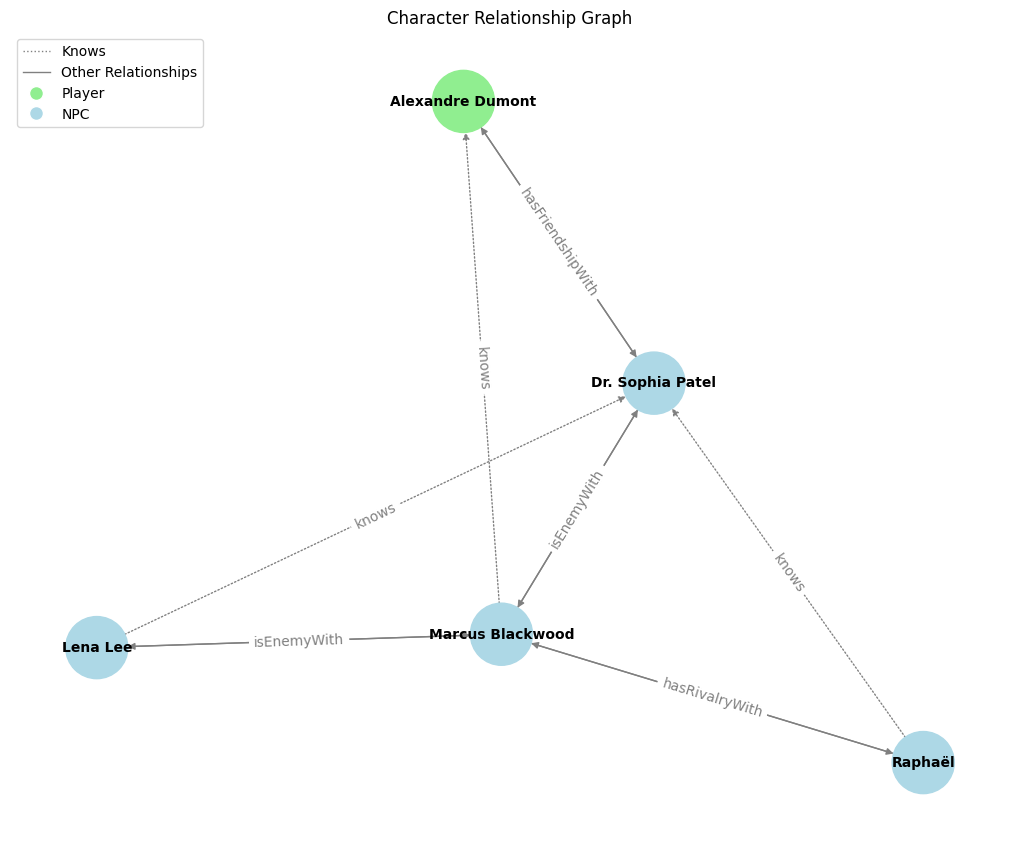

In [112]:
def display_character_relationships(characters):
    plt.figure(figsize=(10, 8))

    # Create a directed graph
    G = nx.DiGraph()

    # Define primary relationship and sub-relationship properties of interest
    knows_relationships = [
        onto.knows,
        onto.hasFriendshipWith, 
        onto.hasAllegiance, 
        onto.hasFamilyTieWith,
        onto.isEnemyWith,
        onto.hasRivalryWith,
        onto.loves,
    ]

    # Create a dictionary to store edge styles
    edge_styles = {}  # Changed from list to dict

    # Add nodes and edges based on relationships
    for prop in knows_relationships:
        for relation in prop.get_relations():
            subject = relation[0].hasName
            obj = relation[1].hasName

            if subject and obj:
                G.add_node(subject)
                G.add_node(obj)

                # Store edge style in dictionary using (subject, obj) as key
                edge_style = 'dotted' if prop.name == 'knows' else 'solid'
                edge_styles[(subject, obj)] = edge_style

                # Determine if an edge already exists between the characters
                existing_edge = G.get_edge_data(subject, obj)

                # Check if the current property is a narrower relationship
                if existing_edge:
                    existing_label = existing_edge['label']
                    existing_property = getattr(onto, existing_label, None)
                    is_narrower_relationship = existing_property in prop.is_a
                else:
                    is_narrower_relationship = True

                # Add or replace the edge with the narrower relationship
                if not existing_edge or is_narrower_relationship:
                    G.add_edge(subject, obj, label=prop.name)

    # Choose a layout
    pos = nx.kamada_kawai_layout(G)

    player_name = onto.Player.instances()[0].hasName
    # Draw nodes with custom color for the player
    node_colors = ['lightgreen' if node == player_name else 'lightblue' for node in G.nodes]
    
    # Draw edges using stored styles
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=node_colors,
        node_size=2000,
        font_size=10,
        font_weight='bold',
        edge_color='gray',
        style=[edge_styles.get((u, v), 'solid') for u, v in G.edges()],  # Get style from dictionary
        arrows=True
    )
    
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="grey", font_size=10)

    # Create legend for edge styles
    legend_elements = [
        Line2D([0], [0], color='gray', lw=1, label='Knows', linestyle='dotted'),
        Line2D([0], [0], color='gray', lw=1, label='Other Relationships', linestyle='solid'),
        Line2D([0], [0], marker='o', color='w', label='Player', markerfacecolor='lightgreen', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='NPC', markerfacecolor='lightblue', markersize=10)
    ]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.title("Character Relationship Graph")
    plt.show()

with onto:
    display_character_relationships(onto.Character.instances())


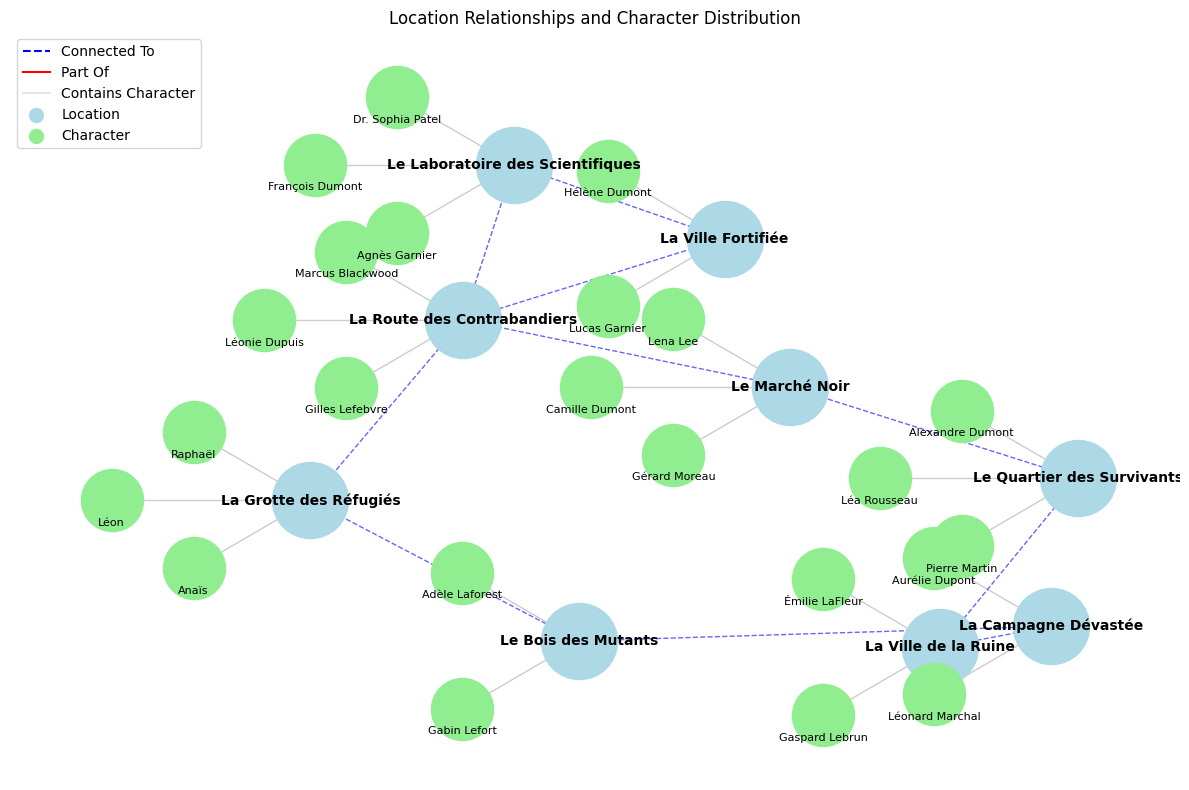

In [111]:
import numpy as np
def display_character_distribution():
    plt.figure(figsize=(12, 8))
    G = nx.Graph()
    
    # Add all locations as nodes and their relationships
    locations = list(onto.Location.instances())
    characters_by_location = {}
    
    # First pass: Add locations and track characters
    for location in locations:
        G.add_node(location.hasName, type='location')
        characters_by_location[location.hasName] = []
        
        # Add characters in this location
        for character in location.containsCharacter:
            G.add_node(character.hasName, type='character')
            G.add_edge(location.hasName, character.hasName, type='contains')
            characters_by_location[location.hasName].append(character.hasName)
    
    # Second pass: Add location relationships
    for location in locations:
        # Add connected locations
        for connected_loc in location.isLinkedToLocation:
            G.add_edge(location.hasName, connected_loc.hasName, type='connected')
    
    
    # Position nodes
    pos = {}
    
    # First, position locations in a circle
    location_nodes = [node for node, attr in G.nodes(data=True) if 'type' not in attr or attr['type'] == 'location']
    location_pos = nx.spring_layout(G.subgraph(location_nodes), k=1.0)
    pos.update(location_pos)
    
    # Then, position characters in a semi-circle around their location
    for location, characters in characters_by_location.items():
        if not characters:
            continue
        
        loc_x, loc_y = pos[location]
        num_chars = len(characters)
        
        # Create a semi-circle of characters around the location
        radius = 0.3  # Distance from location to characters
        for i, character in enumerate(characters):
            angle = np.pi * (0.7 + 0.6 * i / max(1, num_chars - 1))
            char_x = loc_x + radius * np.cos(angle)
            char_y = loc_y + radius * np.sin(angle)
            pos[character] = (char_x, char_y)
    
    # Draw different types of edges
    edges_contains = [(u, v) for (u, v, d) in G.edges(data=True) if d['type'] == 'contains']
    edges_connected = [(u, v) for (u, v, d) in G.edges(data=True) if d['type'] == 'connected']
    edges_partof = [(u, v) for (u, v, d) in G.edges(data=True) if d['type'] == 'partof']
    
    # Draw locations
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=location_nodes, 
                          node_color='lightblue', 
                          node_size=3000)
    
    # Draw characters
    character_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'character']
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=character_nodes, 
                          node_color='lightgreen', 
                          node_size=2000)
    
    # Draw different types of edges
    nx.draw_networkx_edges(G, pos, edgelist=edges_contains, alpha=0.2, style='-')
    nx.draw_networkx_edges(G, pos, edgelist=edges_connected, alpha=0.6, style='--', edge_color='blue')
    nx.draw_networkx_edges(G, pos, edgelist=edges_partof, alpha=0.6, style='-', edge_color='red', arrows=True)
    
    # Draw labels
    location_labels = {node: node for node in location_nodes}
    character_labels = {node: node for node in character_nodes}
    
    nx.draw_networkx_labels(G, pos, 
                           location_labels, 
                           font_size=10, 
                           font_weight='bold')
    
    # Slightly offset character labels
    char_pos = {node: (coord[0], coord[1] - 0.08) for node, coord in pos.items() if node in character_nodes}
    nx.draw_networkx_labels(G, char_pos, 
                           character_labels, 
                           font_size=8)
    
    # Add legend
    legend_elements = [
        Line2D([0], [0], color='blue', linestyle='--', label='Connected To'),
        Line2D([0], [0], color='red', label='Part Of'),
        Line2D([0], [0], color='gray', linestyle='-', alpha=0.2, label='Contains Character'),
        plt.scatter([], [], c='lightblue', s=100, label='Location'),
        plt.scatter([], [], c='lightgreen', s=100, label='Character')
    ]
    plt.legend(handles=legend_elements, loc='upper left')
    
    plt.title("Location Relationships and Character Distribution")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

display_character_distribution()


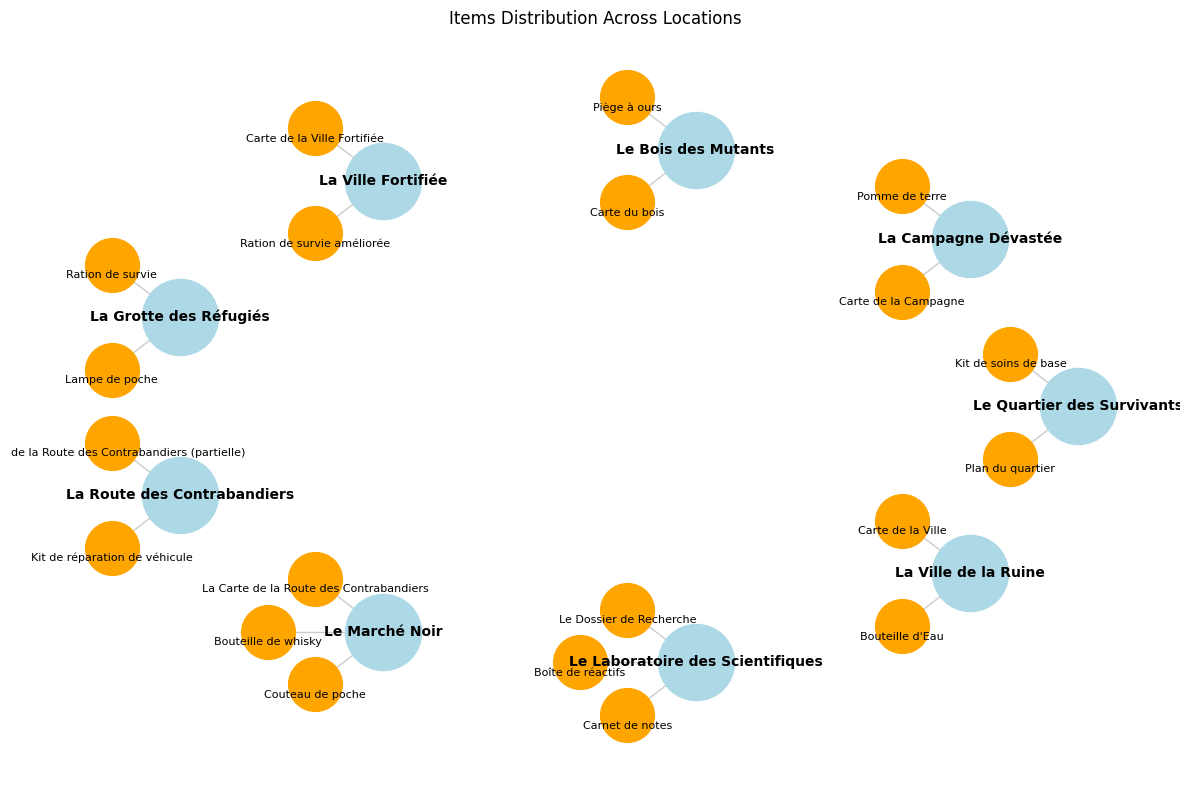

In [100]:
def display_item_distribution():
    plt.figure(figsize=(12, 8))
    G = nx.Graph()
    
    # Add all locations as nodes
    locations = list(onto.Location.instances())
    items_by_location = {}
    
    for location in locations:
        G.add_node(location.hasName, type='location')
        items_by_location[location.hasName] = []
        
        # Add items in this location and connect them
        for item in location.containsItem:
            G.add_node(item.hasName, type='item')
            G.add_edge(location.hasName, item.hasName)
            items_by_location[location.hasName].append(item.hasName)
    
    # Use a circular layout for locations, then adjust item positions
    pos = {}
    
    # First, position locations in a circle
    location_nodes = [node for node, attr in G.nodes(data=True) if 'type' not in attr or attr['type'] == 'location']
    location_pos = nx.circular_layout(G.subgraph(location_nodes), scale=2.0)
    pos.update(location_pos)
    
    # Then, position items in a semi-circle around their location
    for location, items in items_by_location.items():
        if not items:
            continue
        
        loc_x, loc_y = pos[location]
        num_items = len(items)
        
        # Create a semi-circle of items around the location
        radius = 0.5  # Distance from location to items
        for i, item in enumerate(items):
            angle = np.pi * (0.7 + 0.6 * i / max(1, num_items - 1))  # Spread items in a 180-degree arc
            item_x = loc_x + radius * np.cos(angle)
            item_y = loc_y + radius * np.sin(angle)
            pos[item] = (item_x, item_y)
    
    # Draw locations
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=location_nodes, 
                          node_color='lightblue', 
                          node_size=3000)
    
    # Draw items
    item_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'item']
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=item_nodes, 
                          node_color='orange', 
                          node_size=1500)
    
    # Draw edges with some transparency
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    # Draw labels with different colors and slight offsets for better readability
    location_labels = {node: node for node in location_nodes}
    item_labels = {node: node for node in item_nodes}
    
    nx.draw_networkx_labels(G, pos, 
                           location_labels, 
                           font_size=10, 
                           font_weight='bold')
    
    # Slightly offset item labels
    item_pos = {node: (coord[0], coord[1] - 0.08) for node, coord in pos.items() if node in item_nodes}
    nx.draw_networkx_labels(G, item_pos, 
                           item_labels, 
                           font_size=8)
    
    plt.title("Items Distribution Across Locations")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

display_item_distribution()

In [87]:
PLAYER_EXPANSION_PROMPT = """
Using the following details, generate a JSON output with additional information about the player.

Player Name: {{player.hasName}}
Description: {{player.hasDescription}}
Starting location: {{player.INDIRECT_isLocatedAt.hasName}}

{%- if player.INDIRECT_isLocatedAt.containsItem %}
Items in the starting location:
{%- for item in player.INDIRECT_isLocatedAt.containsItem %}
    - {{ item.hasName }}: {{item.hasDescription}}
{%- endfor %}
{%- endif %}

{%- if player.INDIRECT_knows %}
Other main characters of the story:
{%- for char in player.INDIRECT_knows %}
    "{{ char.hasName }}": {{ char.hasDescription }} (is located at {{char.INDIRECT_isLocatedAt.hasName}})
{%- endfor %}
{%- endif %}

Please give the player an inventory, with up to 3 items, such as a weapon, a tool, some consumables, etc. that the player can use to start their adventure.

Use the same JSON format as the example below:
```json
{
    "description": "An updated and expanded description of the player including their goals, motivations, and conflicts.",
    "inventory": [
        {
            "name": "The name of the item",
            "description": "A concise description of the item and its function.",
            "quantity": 1
        },
        ...
    ]
}
```

Output all the JSON value strings in {{ language }}
"""

In [37]:
player_prompt = PromptTemplate(
    template=PLAYER_EXPANSION_PROMPT,
    template_format='jinja2'
)

prompt = player_prompt.invoke({"player": onto.Player.instances()[0],
                              "language": language})
print(prompt.text)

parser = JsonOutputParser()

chain = player_prompt | model | parser

player_expansion = chain.invoke({"player": onto.Player.instances()[0],
                    "language": language})
print(player_expansion)


Using the following details, generate a JSON output with additional information about the player.

Player Name: Alexandre Dumont
Description: Un survivant déterminé à retrouver un sens à sa vie après avoir perdu ses proches dans l'épidémie.
Starting location: Le Quartier des Survivants
Items in the starting location:
    - Kit de soins de base: Un kit contenant des bandages, des antiseptiques et des médicaments de base pour soigner les blessures.
    - Plan du quartier: Un plan détaillé du quartier, indiquant les points de défense, les ressources disponibles et les zones à éviter.
Other main characters of the story:
    "Dr. Sophia Patel": Une scientifique déterminée à trouver un remède à l'épidémie, qui dirige le laboratoire des scientifiques. (is located at Le Laboratoire des Scientifiques)
    "Alexandre Dumont": Un survivant déterminé à retrouver un sens à sa vie après avoir perdu ses proches dans l'épidémie. (is located at Le Quartier des Survivants)

Please give the player an in

In [38]:
# Add the new information to the KG
with onto:
    player = onto.Player.instances()[0]
    player.hasLongDescription = player_expansion.get('description')

    print(f"Long description of the player: {player.hasLongDescription}")

    print("Items in the player's inventory:")
    # Add the items in the player's inventory to the KG
    for item in player_expansion.get('inventory'):
        item_name = item.get('name')
        item_description = item.get('description')
        item_quantity = item.get('quantity')
        item_encoded_name = encode_entity_name(item_name)

        print(f" - {item_name}: {item_description}")

        item = onto.Item(item_encoded_name)
        item.hasName = item_name
        item.hasDescription = item_description
        item.hasQuantity = item_quantity

        player.ownsItem.append(item)


Long description of the player: Un survivant déterminé à retrouver un sens à sa vie après avoir perdu ses proches dans l'épidémie, cherchant à trouver un but et à surmonter ses peurs.
Items in the player's inventory:
 - Couteau de poche: Un petit couteau utile pour se défendre et couper des cordes ou des tissus.
 - Kit de soins de base: Un kit contenant des bandages, des antiseptiques et des médicaments de base pour soigner les blessures.
 - Eau de vie: Une bouteille d'eau de vie qui peut être utilisée pour se soigner ou comme moyen d'échange.


In [39]:
with onto:
    onto.save(file="story_poptest70b.rdf", format="rdfxml")

# Pre-generate the first message


In [46]:
FIRST_TURN_PROMPT = """
You are an LLM designed to act as the engine for a text adventure game set in "{{setting}}".

List of the locations that make up this game's world (to give you general context):
{%- for location in locations %}
    - {{ location.hasName }}: {{location.hasDescription}}
{%- endfor %}

The player is located at {{player_start_location_name}}.
The locations accessible from where the player is are {{nearby_locations_names}}

{%- if characters_nearby %}
Characters present in {{location.hasName}}:
{%- for character in characters_nearby %}
    - {{ character.hasName }}: {{character.hasDescription}} (narrative importance {{character.hasImportance}})
{%- endfor %}
{%- else %}
    There are no other characters present in {{location.hasName}}.
{%- endif %}

{%- if items_nearby %}
Items present in {{location.hasName}}:
{%- for item in items_nearby %}
    - {{ item.hasName }}: {{item.hasDescription}} (narrative importance {{item.hasImportance}})
{%- endfor %}
{%- else %}
    There are no items present in {{location.hasName}}.
{%- endif %}

{%- if player.INDIRECT_ownsItem %}
Items in the player's inventory:
{%- for item in player.INDIRECT_ownsItem %}
    - {{ item.hasName }}: {{item.hasDescription}} (narrative importance {{item.hasImportance}})
{%- endfor %}
{%- else %}
    The player has no items in their inventory.
{%- endif %}

You're about to start interacting with the player. The player plays a character in the story:
    "{{player.hasName}}": {{player.hasDescription}}

The player's goal is: {{player.hasGoal[0].hasDescription}}

You need to write an SHORT introduction, explaining where the player is, who they are, and give them a motivation to reach their goal.
Keep in mind that more things can and should be revealed later, after interaction with the player, so feel free to keep some information to yourself for later.
Keep in mind that not everything that is in a location is necessarily immediately visible or known to the player. Things can be hidden within a location, and a location can be quite large.

The game is played by interactions between the game (you) and the player. You will first produce a setting, then the player will type in natural language whatever they want to do, etc.
Do not reveal everything all at once: let the player discover things.
Only output natural text, as one would read in a book they actually were the hero of.
Do not output the literal names of locations, characters, or items, but blend their mention into the text.
Do not list explicit options.
Do not reveal all the given information at once.
Do not reveal character names unless the player knows them.

**Your message should be one paragraph at most.**

Your entire output will be visible to the player, so stay in your role of narrator ! All your output should be in {{language}}
"""

In [47]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

prompt = PromptTemplate(
    template=FIRST_TURN_PROMPT,
    template_format='jinja2'
)

with onto:
    player = list(onto.Player.instances())[0]
    current_location = player.INDIRECT_isLocatedAt
    locations = onto.Location.instances()
    characters_nearby = current_location.containsCharacter
    locations_nearby = current_location.isLinkedToLocation
    nearby_locations_names = [l.hasName for l in locations_nearby]
    items_nearby = current_location.containsItem

    parameters = {
        'setting': setting,
        'locations': locations,
        'location': current_location,
        'characters_nearby': characters_nearby,
        'items_nearby': items_nearby,
        'player': player,
        'player_start_location_name': current_location.hasName,
        'nearby_locations_names': nearby_locations_names,
        'language': language
    }

    # test the prompt generation
    print(prompt.invoke(parameters).text)

chain = prompt | model
adventure_start = chain.invoke(parameters)



You are an LLM designed to act as the engine for a text adventure game set in "post-apocalypse zombie mondiale, 1 an après le début de l'épidémie".

List of the locations that make up this game's world (to give you general context):
    - La Ville de la Ruine: Une grande ville en ruine, où les hordes de zombies infestent les rues et les bâtiments. Les survivants y sont rares et les ressources sont très limitées.
    - La Campagne Dévastée: Une zone rurale dévastée, où les ressources sont rares et les dangers nombreux. Les survivants y vivent dans des fermes fortifiées ou des villages isolés.
    - Le Quartier des Survivants: Un quartier de la ville où les survivants se sont regroupés pour se protéger mutuellement. Les ressources y sont limitées, mais les survivants y sont plus nombreux et mieux organisés.
    - Le Marché Noir: Un marché clandestin où les survivants échangent des biens et des services. Les trafiquants et les bandits y sont nombreux, mais les survivants peuvent y trouve

In [45]:
print(adventure_start.content)

Vous vous trouvez dans un quartier en ruine de la grande ville, où les survivants se sont regroupés pour se protéger mutuellement. Vous êtes Alexandre Dumont, un survivant déterminé à retrouver un sens à sa vie après avoir perdu vos proches dans l'épidémie. Vous avez entendu parler d'un laboratoire où des scientifiques travaillent à trouver un remède à l'épidémie, et vous êtes déterminé à les rejoindre pour aider à développer ce remède. Vous regardez autour de vous, et vous voyez des survivants qui s'affairent à améliorer les défenses du quartier, d'autres qui se reposent après une longue nuit de veille, et Léa Rousseau, une jeune femme qui fabrique des pièges pour se protéger des morts-vivants. Qu'allez-vous faire ?


Great ! Now we have the first message that will be sent when the player starts their game !
Let's get onto the conversation loop now ! (chat.ipynb)
